## Springboard take home challenge 2: relax, inc

<div class="span5 alert alert-info">
**DESCRIPTION OF THE DATA:**  
**takehome_users.csv:**  
A user table with data on 12,000 users who signed up for the product in the last two  years.   This table includes:  
● name:  the user's name  
● object_id:   the user's id  
● email:  email address  
● creation_source:   how their account was created.  This takes on one of 5 values:  
○ PERSONAL_PROJECTS:  invited to join another user's personal workspace  
○ GUEST_INVITE:  invited to an organization as a guest (limited permissions)  
○ ORG_INVITE:  invited to an organization (as a full member)  
○ SIGNUP:  signed up via the website  
○ SIGNUP_GOOGLE_AUTH:  signed up using Google Authentication (using a Google email account for their login id)  
● creation_time:  when they created their account  
● last_session_creation_time:  unix timestamp of last login  
● opted_in_to_mailing_list:  whether they have opted into receiving marketing emails  
● enabled_for_marketing_drip:  whether they are on the regular marketing email drip  
● org_id:   the organization (group of users) they belong to  
● invited_by_user_id:  which user invited them to join (if applicable).  

**takehome_user_engagement.csv:**  
A usage summary table that has a row for each day that a user logged into the product.  
</div>

<div class="span5 alert alert-info">
**THE ASSIGNMENT:**  
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.
We suggest spending 1 or 2 hours on this, but you're welcome to spend more or less.  Please send us a brief writeup of your findings (the more concise, the better ­­ no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach.  Please note any factors you considered or investigation you did, even if they did not pan out.  Feel free to identify any further research or data you think would be valuable.
</div>

In [430]:
# import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Note: 'takehome_users.csv' was  not encoded to utf-8.  I used encoding to allow proper opening.  (several solutions are presented in stackoverflow, this was the easiest, and seems to work.)

In [431]:
# load login jsons into data frame
# read_csv gave me an error, until I used encoding.  
filepath1 = 'takehome_users.csv'
df1= pd.read_csv(filepath1, encoding='latin1')
print('type:', type(df1))
print('shape', df1.shape)
print('')
print('info',df1.info())
print('')
print('columns:',df1.columns)
users = df1
users.head()

type: <class 'pandas.core.frame.DataFrame'>
shape (12000, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
info None

columns: Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],
      dtype='object'

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [432]:
# clean up null values
users.last_session_creation_time.fillna(0, inplace=True)
users.invited_by_user_id.fillna(0, inplace=True)
# change column name to match the other dataframe
users.rename(columns={'object_id':'user_id'}, inplace=True)
# get domain from email address  (lambda exp from stackoverflow)
users.email = users.email.apply(lambda x: x.split('@')[1].split('.')[0])

#change time stamps to pd.datetime
users.last_session_creation_time = pd.to_datetime(users['last_session_creation_time'])
users.creation_time = pd.to_datetime(users['creation_time'])

email domain names:  
gmail         3562  
yahoo         2447  
jourrapide    1259  
cuvox         1202  
gustr         1179  
hotmail       1165  
all others have 1 or 2 instances

In [433]:
# Regroup small size email domains as one group 'other'
pd.options.mode.chained_assignment = None
domains = ['gmail', 'yahoo', 'jourrapide', 'cuvox', 'gustr', 'hotmail']
users.email[~users.email.isin(domains)] = 'other'
users.email.value_counts()

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
other         1186
gustr         1179
hotmail       1165
Name: email, dtype: int64

In [434]:
print('type:', type(df1))
print('shape', df1.shape)
print('')
print('info',df1.info())
print('')
print('columns:',df1.columns)
users = df1
users.head()

type: <class 'pandas.core.frame.DataFrame'>
shape (12000, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
user_id                       12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB
info None

columns: Index(['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,yahoo,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,gustr,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,gustr,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,yahoo,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,yahoo,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240.0


In [435]:
filepath2 = 'takehome_user_engagement.csv'
df2= pd.read_csv(filepath2, encoding='latin1')
print('type:', type(df2))
print('shape', df2.shape)
print('')
print('info',df2.info())
print('')
print('columns:',df2.columns)
engagement = df2
engagement.head()

type: <class 'pandas.core.frame.DataFrame'>
shape (207917, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
info None

columns: Index(['time_stamp', 'user_id', 'visited'], dtype='object')


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [436]:
#Convert time column to datetime, in case 'time_stamp' is a series or string
engagement.time_stamp = pd.to_datetime(engagement['time_stamp'])

In [437]:
# explore user engagement.  note: I count 'never logged in' 2 different ways to check consistency
print(len(users),'users signed up for the product')
print(len(engagement.user_id.unique()), 'users logged in')
print(len(users)-len(engagement.user_id.unique()), 'never logged in')
print(len(users[users['last_session_creation_time'].isnull()]), 'have never logged in')

visits = engagement['user_id'].value_counts()
visits3 = visits[visits >= 3]
print(len(visits3), 'have logged in at least 3 times')

12000 users signed up for the product
8823 users logged in
3177 never logged in
0 have never logged in
2248 have logged in at least 3 times


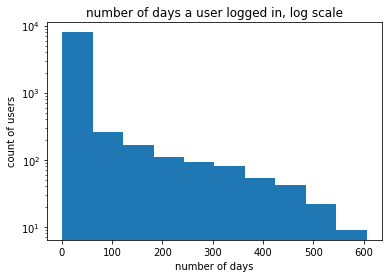

max visits 606
min visits 1
mean visits 23.57


In [438]:
visits = engagement['user_id'].value_counts()
_= plt.hist(visits)
_= plt.title('number of days a user logged in, log scale')
_= plt.yscale("log")
_= plt.xlabel('number of days')
_= plt.ylabel('count of users')
plt.show()

print('max visits',max(visits))
print('min visits',min(visits))
print('mean visits {:0.2f}'.format(np.mean(visits)))

In [439]:
# Count users who logged in 3x in < 7 days
import datetime
seven_days = datetime.timedelta(7)

# users = list of users who logged in at least 3 times ever
visits = engagement['user_id'].value_counts()
users3 = visits[visits >= 3].index

#loop over users, create a list of users who visited 3x in < seven_days
adoption = []
for user in users3:
    # make a data frame of all engagement for user
    user_eng = engagement[engagement.user_id == user]  
    user_eng = user_eng.reset_index().sort_values(by='time_stamp')
    for i in range(0, len(user_eng)-2): 
        time_diff = user_eng.time_stamp[i+2] - user_eng.time_stamp[i]
        if (time_diff < seven_days): 
            status = True
            break
        else:
            status = False
    adoption.append(status)   

user_list = pd.DataFrame({'user_id': users3, 'adopted': adoption})
adopted_list = pd.DataFrame(user_list[user_list.adopted==True])
print(len(adopted_list), 'users adopted the product (used it 3 times in < a week)')

1602 users adopted the product (used it 3 times in < a week)


In [443]:
# absorb adopted_list into users.  
# create users.adopted column.  change adopted_list into dataframe.  merge. 
adopted_df = pd.DataFrame(adopted_list, columns=['user_id', 'adopted'])
users = pd.merge(users, adopted_df, on='user_id', how='outer')
#the merge created adopted_x and adopted_y (y is the value we want to keep)
users.rename(columns={'adopted_y':'adopted'}, inplace=True)
#users = users.drop('adopted_x',axis=1)
users.adopted.fillna('False', inplace=True)
print(users.adopted.value_counts())

False    10398
True      1602
Name: adopted, dtype: int64


This will be the target/predicted value:
True      1602
False    10398
Name: adopted, dtype: int64

adopted accounts are 13.3500% out of 12000 observations


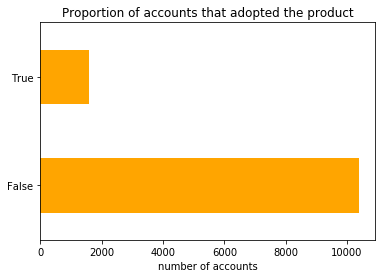

In [418]:
#look at the proportion adopted accounts
print('This will be the target/predicted value:')
print(users['adopted'].value_counts(ascending=True))
print('')
d= users.adopted.value_counts()
print("adopted accounts are {:0.4f}% out of {} observations".format(100* d[1]/(d[1]+d[0]), d[1]+d[0]))
_= d.plot(kind='barh', color='orange')
_= plt.xlabel('number of accounts')
_= plt.title('Proportion of accounts that adopted the product')
plt.show()

In [442]:
users.columns

Index(['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'adopted'],
      dtype='object')

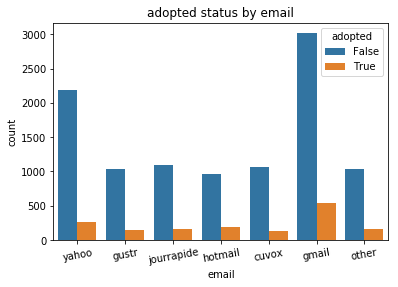

In [420]:
sns.countplot(x='email', hue='adopted', data=users)
plt.title('adopted status by email')
plt.xlabel('email')
plt.ylabel('count')
plt.xticks(rotation=10)
plt.show()

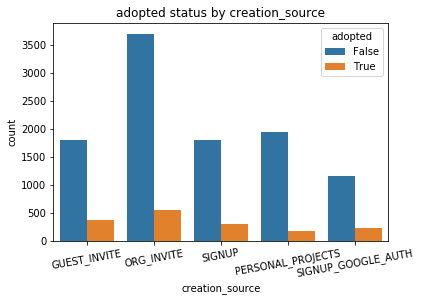

In [421]:
sns.countplot(x='creation_source', hue='adopted', data=users)
plt.title('adopted status by creation_source')
plt.xlabel('creation_source')
plt.ylabel('count')
plt.xticks(rotation=10)
plt.show()

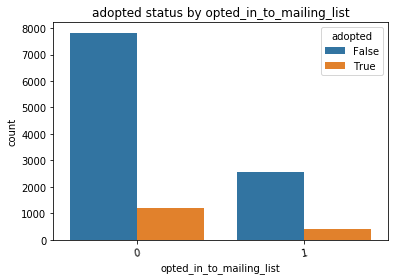

In [422]:
sns.countplot(x='opted_in_to_mailing_list', hue='adopted', data=users)
plt.title('adopted status by opted_in_to_mailing_list')
plt.xlabel('opted_in_to_mailing_list')
plt.ylabel('count')
plt.xticks(rotation=10)
plt.show()

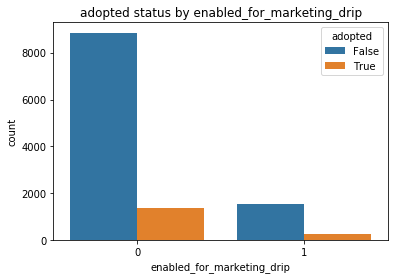

In [423]:
sns.countplot(x='enabled_for_marketing_drip', hue='adopted', data=users)
plt.title('adopted status by enabled_for_marketing_drip')
plt.xlabel('enabled_for_marketing_drip')
plt.ylabel('count')
plt.xticks(rotation=0)
plt.show()

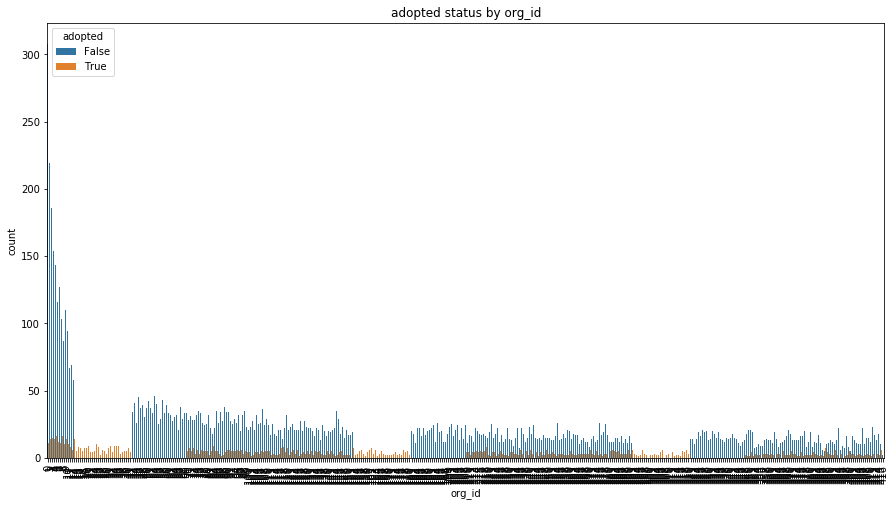

In [424]:
plt.figure(figsize=(15,8))

plt.figure(figsize=(15,8))
ax = sns.countplot(x='org_id', hue='adopted', data=users)
plt.title('adopted status by org_id')
plt.xlabel('org_id')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()

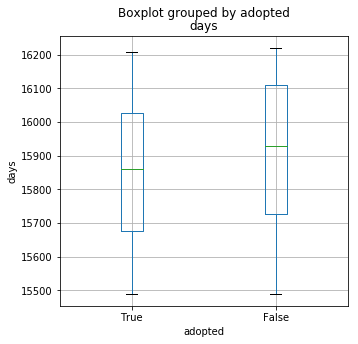

In [452]:
# plot adopted vs not adopted by how many days between creation and last session
users['days'] = (users.creation_time - users.last_session_creation_time).apply(lambda x: x.days)
_= users.boxplot(column='days',by='adopted', figsize=(5,5))
_= plt.ylabel('days')
plt.show()

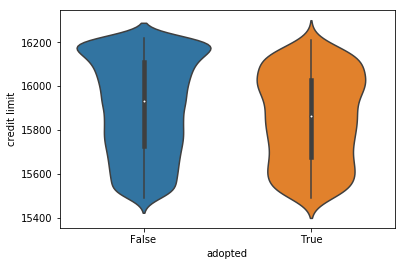

In [453]:
_= sns.violinplot(x='adopted', y='days', data=users)
_= plt.ylabel('credit limit')
plt.show()

In [454]:
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_x,adopted,days
0,1,2014-04-22 03:53:30,Clausen August,yahoo,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803.0,NaN,False,16182
1,2,2013-11-15 03:45:04,Poole Matthew,gustr,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0,True,True,16024
2,3,2013-03-19 23:14:52,Bottrill Mitchell,gustr,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525.0,NaN,False,15783
3,4,2013-05-21 08:09:28,Clausen Nicklas,yahoo,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151.0,NaN,False,15846
4,5,2013-01-17 10:14:20,Raw Grace,yahoo,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240.0,NaN,False,15722


In [451]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler

# Standardize the data frame, and create X for predictor variables, y for target
X = users.drop(['adopted','user_id'], axis=1).values
y = users['adopted'].values
target = 'adopted'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [448]:
# Normalize data
scaler = StandardScaler()
scaler.fit(X_train) # use train data to fit
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

TypeError: float() argument must be a string or a number, not 'Timestamp'